# **Convolutional Neural Network Model**

## **Model Preprocessing**

### **Installing and Importing Tensorflow**

In [ ]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3 MB 12 kB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 3.8 MB 58.9 MB/s 
     |████████████████████████████████| 449 kB 39.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=101bf7bd508e08e44e7b98baa47e9472d04de35ccc0c9a5eeac1b42ee208388d
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [ ]:
import tensorflow as tf
%load_ext tensorboard
tf.random.set_seed(42)
tf.__version__

'2.6.0'

### **Importing the dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Dataset Details**

In [ ]:
ls "/content/drive/My Drive/Malaria Detection /CNN/" 

Parasitized/  Uninfected/


In [ ]:
!tree --dirsfirst --filelimit 5 "/content/drive/My Drive/Malaria Detection /CNN/"

/bin/bash: tree: command not found


In [ ]:
import os
import glob

base_dir = os.path.join('/content/drive/My Drive/Malaria Detection /CNN/')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
print ('number of infected cells is ',len(infected_files),' number of healthy cells is ',len(healthy_files))


number of infected cells is  13864  number of healthy cells is  13904


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/My Drive/Malaria Detection /CNN...,malaria
1,/content/drive/My Drive/Malaria Detection /CNN...,malaria
2,/content/drive/My Drive/Malaria Detection /CNN...,healthy
3,/content/drive/My Drive/Malaria Detection /CNN...,malaria
4,/content/drive/My Drive/Malaria Detection /CNN...,healthy


### **Create Train , Validation and Testing sets**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, val_files, train_labels, val_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
print(train_files.shape, val_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels))

(19437,) (8331,)
Train: Counter({'healthy': 9763, 'malaria': 9674}) 
Val: Counter({'malaria': 4190, 'healthy': 4141})


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17493,) (1944,) (8331,)
Train: Counter({'healthy': 8789, 'malaria': 8704}) 
Val: Counter({'healthy': 974, 'malaria': 970}) 
Test: Counter({'malaria': 4190, 'healthy': 4141})


### **Load and Resize Training and Validation Images**

In [ ]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Training Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Training Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_12: working on img num: 5000
ThreadPoolExecutor-0_2: working on img num: 10000
ThreadPoolExecutor-0_16: working on img num: 15000
ThreadPoolExecutor-0_2: working on img num: 17492

Loading Validation Images:
ThreadPoolExecutor-0_15: working on img num: 0
ThreadPoolExecutor-0_17: working on img num: 1943

Loading Test Images:
ThreadPoolExecutor-0_18: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 5000
ThreadPoolExecutor-0_14: working on img num: 8330


((17493, 125, 125, 3), (1944, 125, 125, 3), (8331, 125, 125, 3))

### **Displaying the sets images and lables of each**

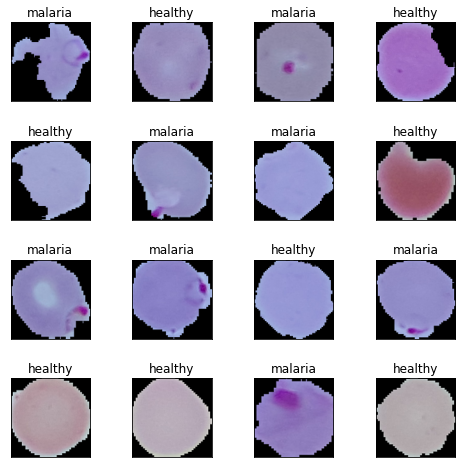

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

### **Images scaling and setup model configurations**

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 6
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['healthy' 'healthy' 'malaria' 'healthy' 'healthy' 'healthy'] [0 0 1 0 0 0]


## **CNN Model**

### **Build Model Architecture**

In [ ]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)

hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

cnn2 = tf.keras.Model(inputs=inp, outputs=out)
cnn2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
cnn2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

### **Train Model**

In [ ]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = cnn2.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=2, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/2
274/274 [==============================] - 310s 1s/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.3202 - val_accuracy: 0.9542
Epoch 2/2
274/274 [==============================] - 317s 1s/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.3178 - val_accuracy: 0.9547


### **Trainning Accuracy and Validating Accuracy**

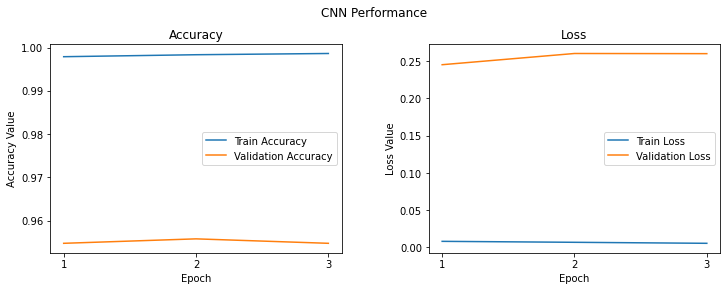

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## **Save Model**

In [ ]:
model.save_weights('/content/drive/My Drive/Malaria Detection /basic_cnn2_6.h5')

In [ ]:
model.save('/content/drive/My Drive/Malaria Detection /basic_cnn2_6.h5')

## **Model Evaluation Metrics**


In [ ]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, val_labels.shape

((8331, 125, 125, 3), (1944,))

In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 4.0 MB/s 
     |████████████████████████████████| 15.7 MB 165 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
google-co

In [ ]:
cnn = tf.keras.models.load_model('/content/drive/My Drive/Malaria Detection /basic_cnn2_6.h5')

In [ ]:
cnn_preds = cnn.predict(test_imgs_scaled, batch_size=512)
cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in cnn_preds.ravel()])

### **Confusion matrix** 

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
cf_matrix = confusion_matrix(test_labels,cnn_pred_labels)
print(cf_matrix)

[[3988  153]
 [ 221 3969]]


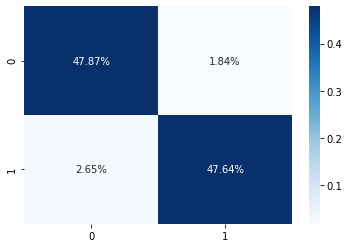

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

###**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(test_labels,cnn_pred_labels)
accuracy

0.9551074300804225

###**Error Rate**

In [ ]:
Error_rate=1-(accuracy)
print(Error_rate)

0.04489256991957746


### **Precision**

In [ ]:
from sklearn.metrics import precision_score
positive = precision_score(test_labels,cnn_pred_labels,pos_label='healthy')
print(positive)

0.9474934663815633


In [ ]:
negative = precision_score(test_labels,cnn_pred_labels,pos_label='malaria')
print(negative)

0.962882096069869


###**Recall**

In [ ]:
from sklearn.metrics import recall_score
positive = recall_score(test_labels,cnn_pred_labels,pos_label='healthy')
print(positive)

0.9630524028012557


In [ ]:
negative = recall_score(test_labels,cnn_pred_labels,pos_label='malaria')
print(negative)

0.947255369928401


### **F1 Score**

In [ ]:
from sklearn.metrics import f1_score
postive = f1_score(test_labels,cnn_pred_labels,pos_label='healthy')
print(postive)

0.9552095808383234


In [ ]:
negative = f1_score(test_labels,cnn_pred_labels,pos_label='malaria')
print(negative)

0.955004812319538


### **Specificity**

In [ ]:
specificity = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print (specificity)

0.947255369928401
